In [194]:
from pathlib import Path
from tensorflow.python.keras.callbacks import EarlyStopping
%matplotlib inline
import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os

from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
import keras.backend as K
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# load/preprocess images

In [195]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [196]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [197]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


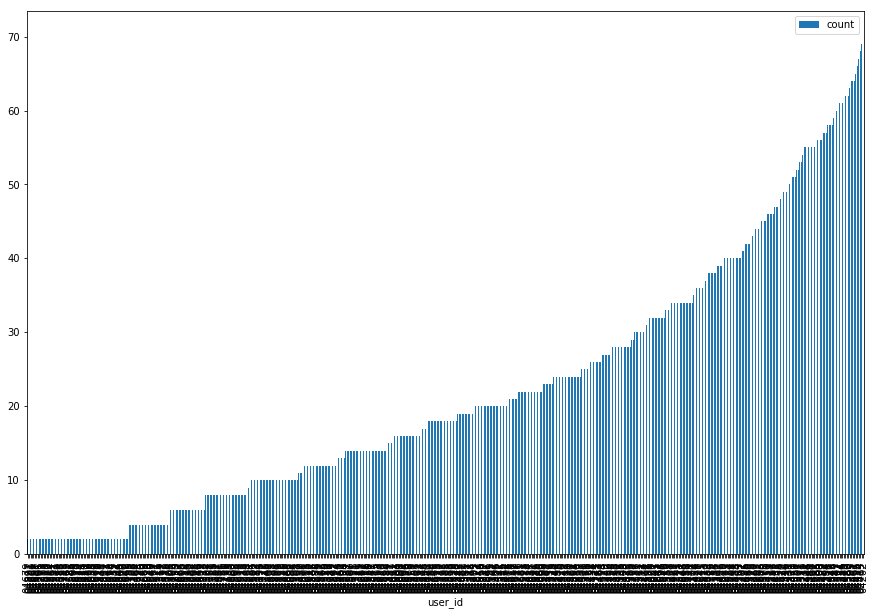

In [198]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [200]:
# Get all classes from 10 samples till 60 samples
data_size = 10

ids_testing = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() < data_size
)

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)

ids_to_keep = ids_to_keep[ids_to_keep].index
ids_test = ids_testing[ids_testing].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(60)
    .copy()
)

test_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_test)]
    .sample(frac=1)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

test_unique = test_df['user_id'].nunique()
print(f"There are {test_unique} IDS for testing")

There are 416/568 (73.24%) unique IDs remaining.
There are 152 IDS for testing


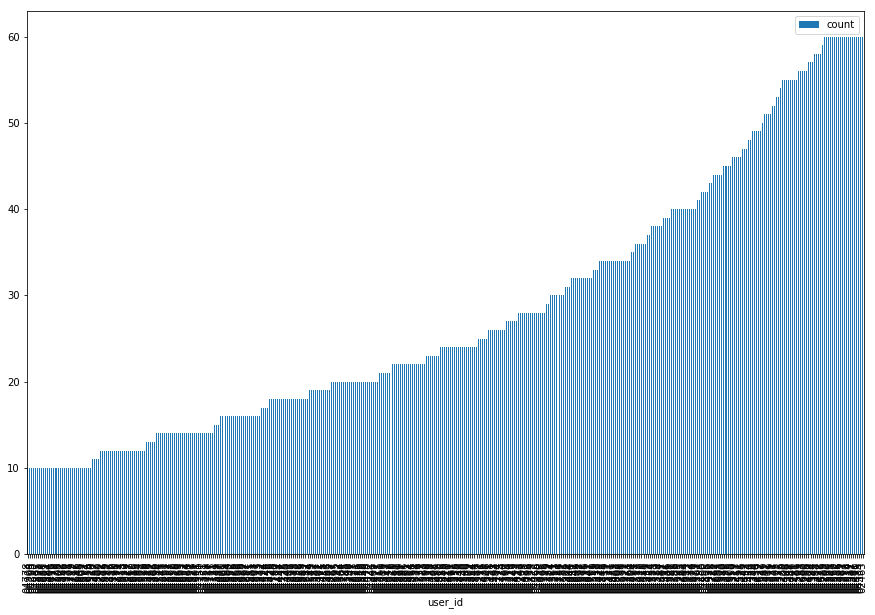

In [201]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [202]:
subset_directory_df.head()
subset_directory_df_sorted = subset_directory_df.sort_values(by=['path'])
test_df_sorted = test_df.sort_values(by=['path'])

In [215]:
subset_directory_df_sorted

,user_id,user_img_id,path
4957,02463,170,frgc32x32/02463d170.png
11388,02463,184,frgc32x32/02463d184.png
10746,02463,194,frgc32x32/02463d194.png
8489,02463,214,frgc32x32/02463d214.png
43,02463,224,frgc32x32/02463d224.png
6414,02463,238,frgc32x32/02463d238.png
5877,02463,252,frgc32x32/02463d252.png
3428,02463,256,frgc32x32/02463d256.png
1401,02463,258,frgc32x32/02463d258.png
6272,02463,263,frgc32x32/02463d263.png


In [162]:
from imgaug import augmenters as iaa

def augment(image):
    # https://github.com/aleju/imgaug
    augmentations = iaa.Sequential([
        iaa.SaltAndPepper(0.03),
    #     iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #     iaa.AdditiveLaplaceNoise(scale=(0, 0.03*255)),
    #     iaa.CoarseDropout((0.01, 0.04), size_percent=(0.02, 0.18))
    ])
    seq = augmentations
    return seq(image=image)

In [181]:
from tqdm import tqdm
def load_images(dataframe):
    _labels = []

    items = []
    for _, row in tqdm(dataframe.iterrows(), desc='loading images'):
        img = cv2.imread(row['path'], 0)
        img = cv2.resize(img, (32, 32))
        if row['user_id'] not in _labels:
            _labels.append(row['user_id'])
        lbl = _labels.index(row['user_id'])
        items.append((img, lbl))
    return items

items = load_images(subset_directory_df_sorted)
test_items = items = load_images(test_df_sorted)

loading images: 11591it [00:04, 2594.38it/s]
loading images: 646it [00:00, 2630.41it/s]


In [186]:
len(items)

646

In [165]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = new_unique

    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [168]:
train_test_split = 0.7
split = int(train_test_split * new_unique) * 20

with open ('identities.txt', 'w+') as f:
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][:split]]) + '\n')
    f.write(', '.join([img for img in subset_directory_df_sorted['path'][split:]]) + '\n')

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

valX = np.array([x[0] for x in items[split:]])
valY = np.array([x[1] for x in items[split:]])

testX = np.array([x[0] for x in test_items])
testY = np.array([x[1] for x in test_items])

trainX = trainX / 255.0
valX = valX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
valX = np.expand_dims(valX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairVal, labelVal) = make_pairs(valX, valY)
(pairTest, labelTest) = make_pairs(testX, testY)


# build model

In [53]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 100

In [54]:
def build_model_20(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(48, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_20')

    return model


In [55]:
def build_model_60(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_60')

    return model

In [56]:
def build_model_130(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(80, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(48, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_130')

    return model

In [57]:
def build_model_250(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(128, (5, 5), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(96, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs, name = 'model_250')

    return model

In [58]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    featsA = vectors[0]
    featsB = vectors[1]
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [59]:
def train_model(model_fun, save_name, train = True):
    print(f'Training model: {save_name}')

    base_out = 'output'
    model_path = os.path.sep.join([base_out, f'model_{save_name}'])
    plot_path = os.path.sep.join([base_out, f'plot_{save_name}.png'])

    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = model_fun(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[imgA, imgB], outputs=outputs)

    model.compile(loss="binary_crossentropy", optimizer="adam",
	    metrics=["accuracy"])

    print(model.summary())

    if not train:
        return

    history = model.fit(
        [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        validation_data=([pairVal[:, 0], pairVal[:, 1]], labelVal[:]),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS)

    model.save(model_path)
    plot_training(history, plot_path)

Training model: sn_250
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
model_250 (Functional)          (None, 48)           255536      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           mode

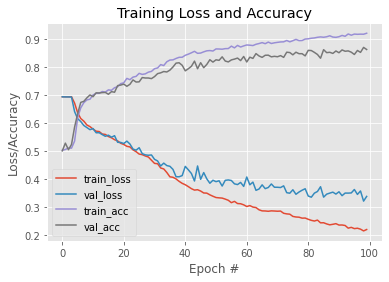

In [60]:
train = True
# train_model(build_model_20, 'sn_20', train)
# train_model(build_model_60, 'sn_60', train)
# train_model(build_model_130, 'sn_130', train)
train_model(build_model_250, 'sn_250', train)